## Code for Cervical Cell Classification

In [2]:
#Importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten
import os
import random
import shutil
import tensorflow as tf
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
pip install timm

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ---------------------------------------- 68.5/68.5 kB 3.6 MB/s eta 0:00:00
  Obtaining dependency information for pyyaml from https://files.pythonhosted.org/packages/24/97/9b59b43431f98d01806b288532da38099cc6f2fea0f3d712e21e269c0279/PyYAML-6.0.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for huggingface-hub from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
     -------------------------------------- 263.7/263.7 kB 8.2 MB/s eta 0:00:00
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/00/45/ec3407adf6f6b5bf867a4462b2b0af27597a26bd3cd6e253

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
# Initializing File Paths
path_to_dys = r"D:\cervical_cells\im_Dyskeratotic\CROPPED"
path_to_koi =r"D:\cervical_cells\im_Koilocytotic\CROPPED"
path_to_met = r"D:\cervical_cells\im_Metaplastic\CROPPED"
path_to_par = r"D:\cervical_cells\im_Parabasal\CROPPED"
path_to_sup = r"D:\cervical_cells\im_Superficial-Intermediate\CROPPED"

file_paths = [path_to_dys,path_to_koi,path_to_met,path_to_par,path_to_sup]


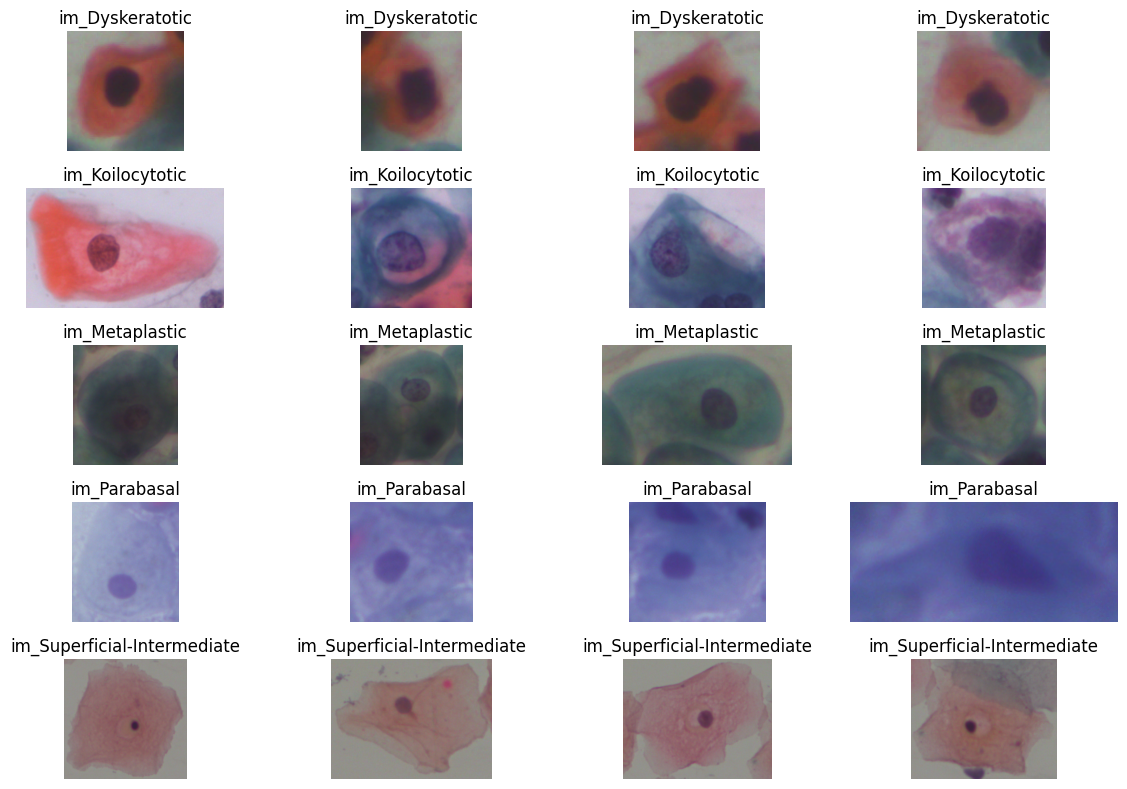

In [5]:
# Function to load and display images
def display_images(file_paths):
    plt.figure(figsize=(12, 8))
    num_images = 4  # Number of images to display
    for i, file_path in enumerate(file_paths):
        # Get the file names of the images in the folder
#         image_files = os.listdir(file_path)
        image_files = [f for f in os.listdir(file_path) if f.lower().endswith('.bmp')]
        # Load and display a few images
        for j in range(num_images):
            img_path = os.path.join(file_path, image_files[j])
            img = plt.imread(img_path)
            plt.subplot(len(file_paths), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis('off')
            cell_name = file_path.split('\\')[-2]
            plt.title(cell_name)
    plt.tight_layout()
    plt.show()

# Call the function with the file paths
display_images(file_paths)

## Since the folder downloaded from database, contained other files that were not images and not needed for analysis

In [13]:
### Create a new directory to store BMP files which is needed for this analysis
useful_file_directory = r"D:\cervical_cells\cell_images"
os.makedirs(useful_file_directory, exist_ok=True)

def copy_bmp_files(file_paths, useful_file_directory):
    for file_path in file_paths:
        cell_name = file_path.split('\\')[-2]
        cell_directory = os.path.join(useful_file_directory, cell_name)
        os.makedirs(cell_directory, exist_ok=True)
        bmp_files = [f for f in os.listdir(file_path) if f.lower().endswith('.bmp')]
        for bmp_file in bmp_files:
            file_orig = os.path.join(file_path, bmp_file)
            file_dest = os.path.join(cell_directory, bmp_file)
            shutil.copyfile(file_orig, file_dest)

# Calling function to copy BMP files to the output directory
copy_bmp_files(file_paths, useful_file_directory)


# Finding Distribution of images in each class

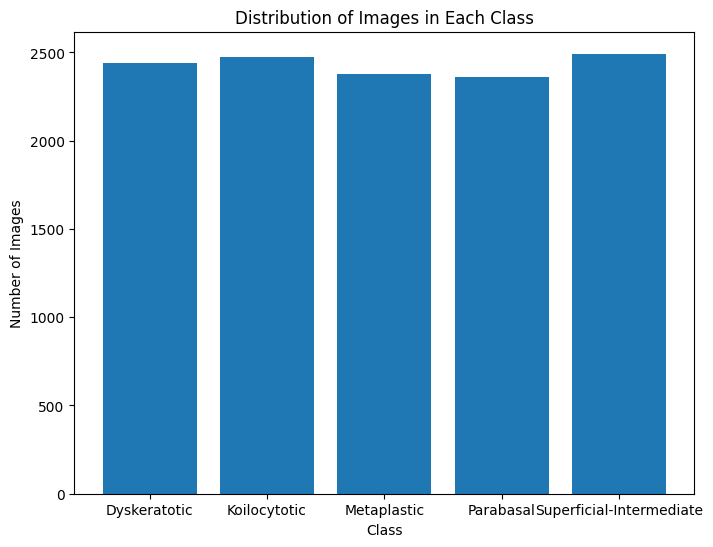

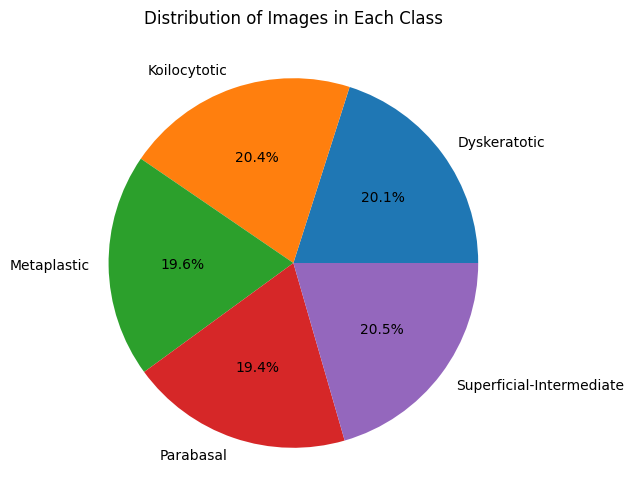

In [13]:
class_names = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']
class_counts = []

# Count the number of images in each class
for path in file_paths:
    file_count = len(os.listdir(path))
    class_counts.append(file_count)

# Plotting a bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.show()

# Plotting a pie plot
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%')
plt.title('Distribution of Images in Each Class')
plt.show()


## Function to Split data

In [18]:
# Function to Split data
def split_data(data_directory, output_directory, train_ratio=0.7, validation_ratio=0.2, test_ratio=0.1, seed=None):
    train_directory = os.path.join(output_directory, "train")
    test_directory = os.path.join(output_directory, "test")
    validation_directory = os.path.join(output_directory, "validation")

    # Creating train, test, and validation directories
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)
    os.makedirs(validation_directory, exist_ok=True)

    # calling the list of all files in the data directory
    all_files = []
    for root, dirs, files in os.walk(data_directory):
        for file in files:
            file_path = os.path.join(root, file)
            all_files.append(file_path)

    # Randomly shuffling files with a seed
    random.seed(seed)
    random.shuffle(all_files)

    # Split the data into train, validation, and test sets
    train_files = all_files[:int(len(all_files) * train_ratio)]
    validation_files = all_files[int(len(all_files) * train_ratio):int(len(all_files) * (train_ratio + validation_ratio))]
    test_files = all_files[int(len(all_files) * (train_ratio + validation_ratio)):]

    # Copying files to the train directory
    for file in train_files:
        file_destin = os.path.join(train_directory, os.path.relpath(file, data_directory))
        os.makedirs(os.path.dirname(file_destin), exist_ok=True)
        shutil.copy2(file, file_destin)

    # Copying files to the validation directory
    for file in validation_files:
        file_destin = os.path.join(validation_directory, os.path.relpath(file, data_directory))
        os.makedirs(os.path.dirname(file_destin), exist_ok=True)
        shutil.copy2(file, file_destin)

    # Copying files to the test directory
    for file in test_files:
        file_destin = os.path.join(test_directory, os.path.relpath(file, data_directory))
        os.makedirs(os.path.dirname(file_destin), exist_ok=True)
        shutil.copy2(file, file_destin)



In [19]:
# Splitting the images into train(0.7),Validation(0.2),test(0.1)

data_directory =  r"D:\cervical_cells\cell_images"
output_directory =  r"D:\cervical_cells\split_unprocessed_images" # Location of split data


In [20]:
# Spliting data into test,train, val

split_data(data_directory, output_directory, seed=42)

# DATA PREPROCESSING

In [28]:
pip install imgaug

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [35]:
pip show imgaug

Name: imgaug
Version: 0.4.0
Summary: Image augmentation library for deep neural networks
Home-page: https://github.com/aleju/imgaug
Author: Alexander Jung
Author-email: kontakt@ajung.name
License: MIT
Location: c:\users\704611\appdata\roaming\python\python310\site-packages
Requires: imageio, matplotlib, numpy, opencv-python, Pillow, scikit-image, scipy, Shapely, six
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [6]:
# importing relevant libraries
import os
import glob
import cv2
import numpy as np
from imgaug import augmenters as iaa
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# Creating function to perform various data augumentation steps 

class ImageAugmenter:
    def __init__(self):
        print("Instance of the ImageAugmenter class created")
        self.augmentors = self.create_augmentors()

    def create_augmentors(self):
        augmentors = [
            # Rotate the image by a random angle between -90 and 90 degrees
            iaa.Affine(rotate=(-90, 90)),

            # Scale the image along the x-axis by a random factor between 0.5 and 0.9,
            # and along the y-axis by a random factor between 0.5 and 0.9
            iaa.Affine(scale={"x": (0.5, 0.9), "y": (0.5, 0.9)}),

            # Translate the image along the x-axis by a random percentage between -15% and 15%,
            # and along the y-axis by a random percentage between -15% and 15%
            iaa.Affine(translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}),

            # Shear the image by a random angle between -2 and 2 degrees
            iaa.Affine(shear=(-2, 2)),

            # Apply a perspective transformation to the image with a random scale between 0.01 and 0.15
            iaa.PerspectiveTransform(scale=(0.01, 0.15), keep_size=True),

            # Flip the image horizontally
            iaa.Fliplr(1.0),

            # Flip the image vertically
            iaa.Flipud(1.0),

            # Crop and pad the image while keeping its size, with a random percent crop between 5% and 25%
            iaa.KeepSizeByResize(iaa.CropAndPad(percent=(0.05, 0.25))),

            # Apply Gaussian blur to the image with a random sigma between 0 and 1.22
            iaa.GaussianBlur(sigma=(0, 1.22)),

            # Adjust the linear contrast of the image by a random factor between 0.75 and 1.5
            iaa.contrast.LinearContrast((0.75, 1.5)),

            # Adjust the linear contrast of each channel of the image independently
            iaa.LinearContrast((0.75, 1.5), per_channel=True),

            # Sharpen the image by changing its alpha and lightness values
            iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

            # Add additive Gaussian noise to the image with a random scale
            iaa.AdditiveGaussianNoise(scale=0.111 * 255, per_channel=True),

            # Add additive Laplace noise to the image with a random scale
            iaa.AdditiveLaplaceNoise(scale=(0, 0.111 * 255)),

            # Multiply the image by a random factor between 0.35 and 1.65
            iaa.Multiply((0.35, 1.65)),

            # Multiply each channel of the image independently by a random factor
            iaa.Multiply((0.5, 1.5), per_channel=0.75),

            # Add a random value between 10 and 100 to the red channel of the image
            iaa.WithChannels(0, iaa.Add((10, 100))),

            # Rotate the red channel of the image by a random angle between 0 and 45 degrees
            iaa.WithChannels(0, iaa.Affine(rotate=(0, 45))),

            # Add a random value between 10 and 100 to the green channel of the image
            iaa.WithChannels(1, iaa.Add((10, 100))),

            # Rotate the green channel of the image by a random angle between 0 and 45 degrees
            iaa.WithChannels(1, iaa.Affine(rotate=(0, 45))),

            # Add a random value between 10 and 100 to the blue channel of the image
            iaa.WithChannels(2, iaa.Add((10, 100))),

            # Rotate the blue channel of the image by a random angle between 0 and 45 degrees
            iaa.WithChannels(2, iaa.Affine(rotate=(0, 45))),

            # Apply alpha blending to the image with a random alpha value and convert it to grayscale
            iaa.BlendAlphaElementwise((0, 1.0), iaa.Grayscale((0, 1.0)))
        ]
        return augmentors


    def augment_image(self, image, augmentor):
        augmented_image = augmentor.augment_image(image)
        return augmented_image

    def save_augmented_image(self, augmented_image, output_path):
        cv2.imwrite(output_path, augmented_image)


class ImageAugmentationExtension:
    def __init__(self, directory=""):
        self.directory = directory
        print("Instance of ImageAugmentationExtension class created")

    def extend_dataset(self, directory):
        augmenter = ImageAugmenter()
        for class_name in os.listdir(directory):
            class_path = os.path.join(directory, class_name)
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    file_path = os.path.join(class_path, file_name)
                    if file_name.endswith('.bmp'):
                        img = cv2.imread(file_path)
                        for i, augmentor in enumerate(augmenter.augmentors):
                            augmented_img = augmenter.augment_image(img, augmentor)
                            output_file_name = f"augmented_{i}.jpg"
                            output_path = os.path.join(class_path, output_file_name)
                            augmenter.save_augmented_image(augmented_img, output_path)





In [8]:
# Definining train,test and validation directory variables
data_directory =  r"D:\cervical_cells\cell_images"   # directory for all the images
output_directory =  r"D:\cervical_cells\split_unprocessed_images" # directory  

train_directory = os.path.join(output_directory, "train")
test_directory = os.path.join(output_directory, "test")
validation_directory = os.path.join(output_directory, "validation")
number_of_class = 5
num_classes = 5

In [9]:
# Performing image augmentation from functions above on the training data to improve image quality
image_augmentation = ImageAugmentationExtension()
image_augmentation.extend_dataset(train_directory)


Instance of ImageAugmentationExtension class created
Instance of the ImageAugmenter class created


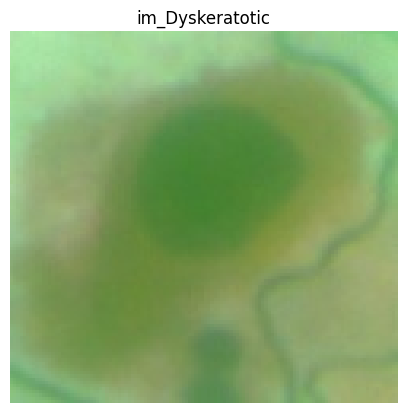

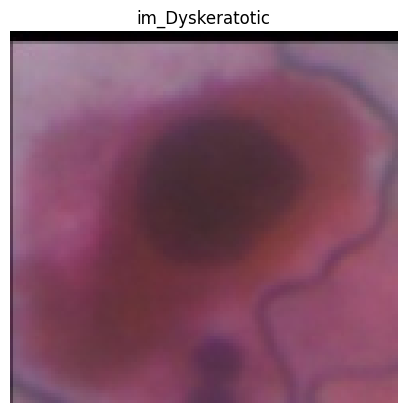

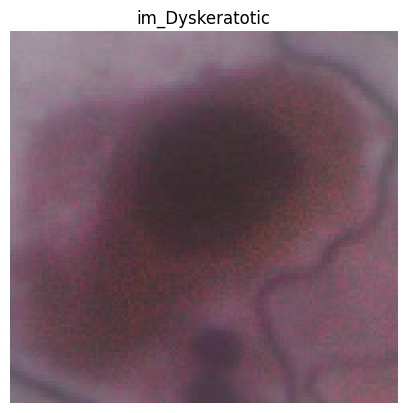

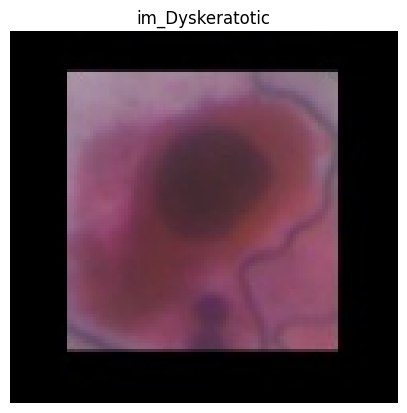

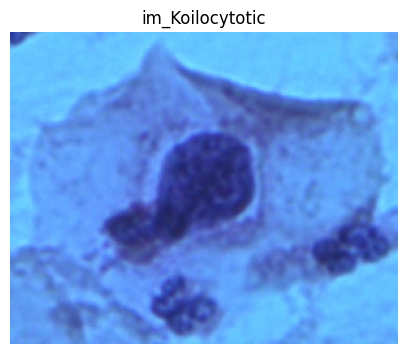

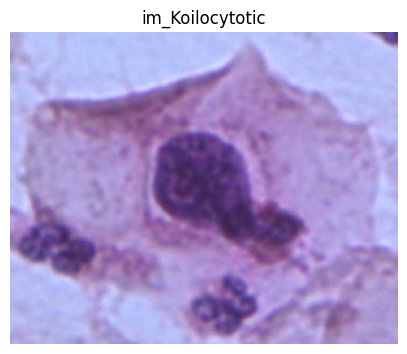

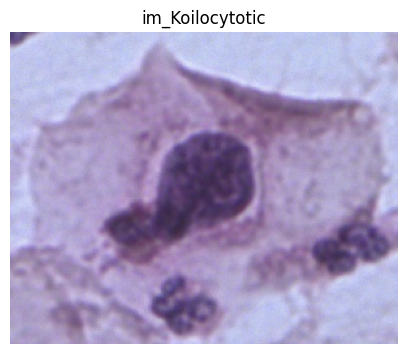

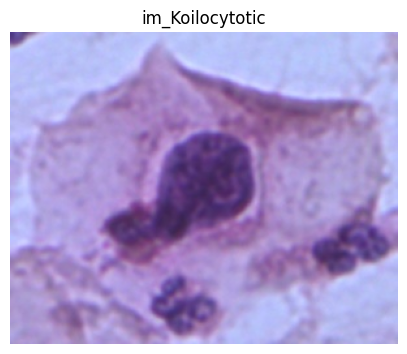

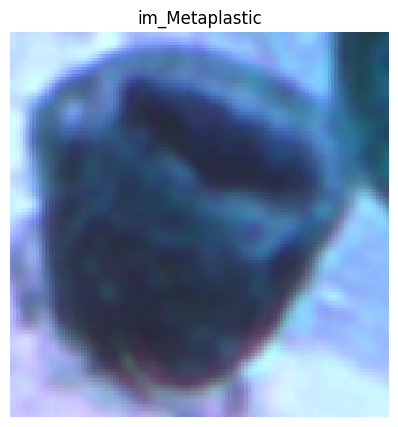

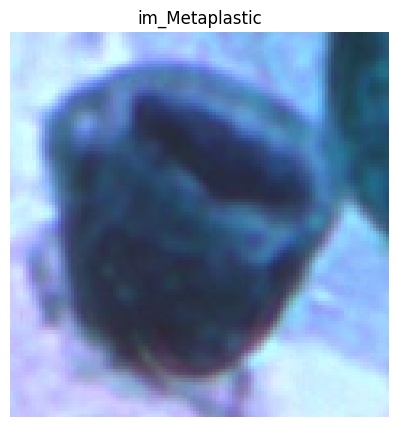

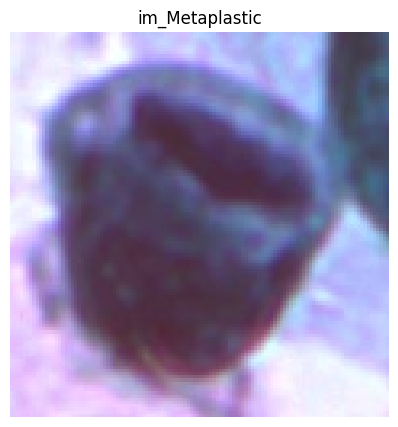

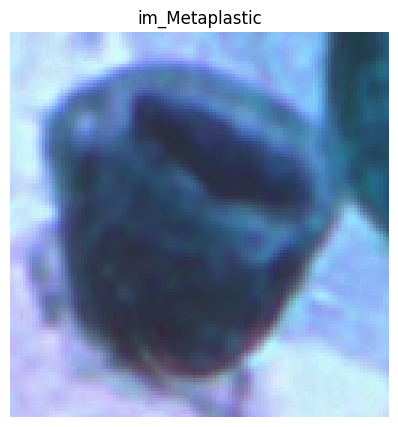

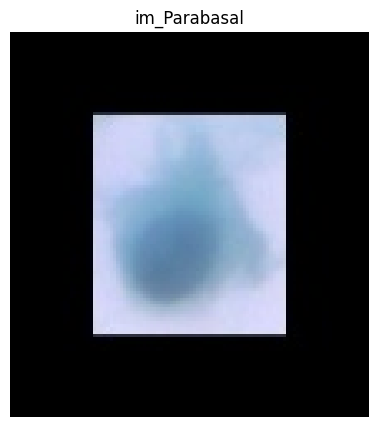

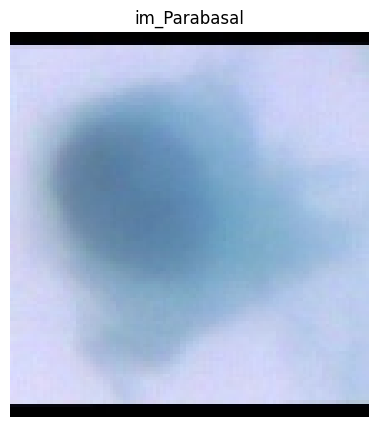

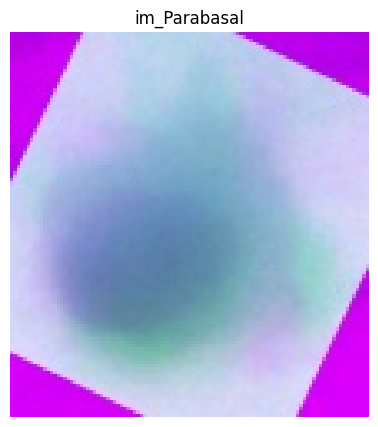

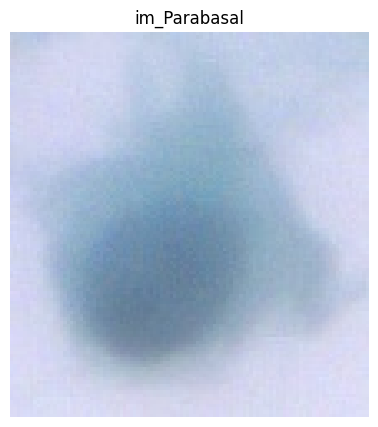

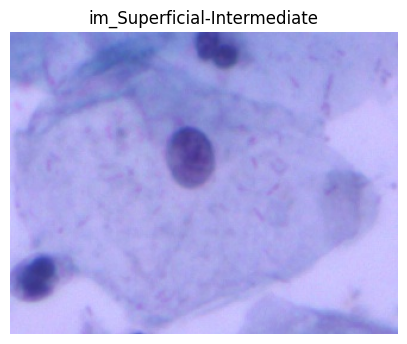

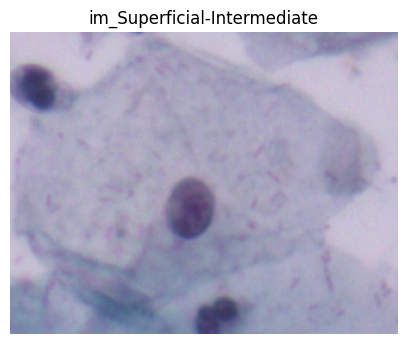

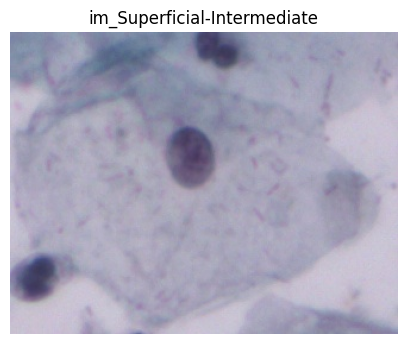

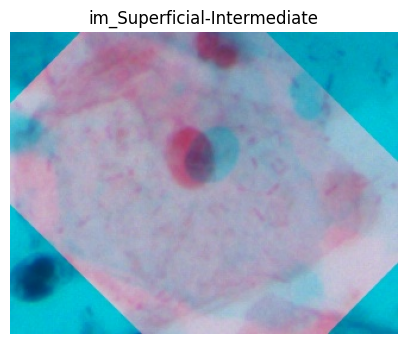

In [10]:
# Viewing impact of the augumentation techniques on the data

class_names = ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']



num_images_to_display = 4

# Iterate over the class indices
for class_index, class_name in enumerate(class_names):

    # path of the current class
    class_path = os.path.join(train_directory, class_name)

    # list of augmented image files
    augmented_files = [file for file in os.listdir(class_path) if file.startswith("augmented_")]

    # To randomly select the desired number of images
    selected_files = random.sample(augmented_files, num_images_to_display)

    # To display the augmented images with labels
    for file_name in selected_files:
        file_path = os.path.join(class_path, file_name)
        augmented_image = cv2.imread(file_path)
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

        # Display the image with the class label
        plt.figure(figsize=(5, 5))
        plt.imshow(augmented_image)
        plt.title(class_name)
        plt.axis('off')
        plt.show()




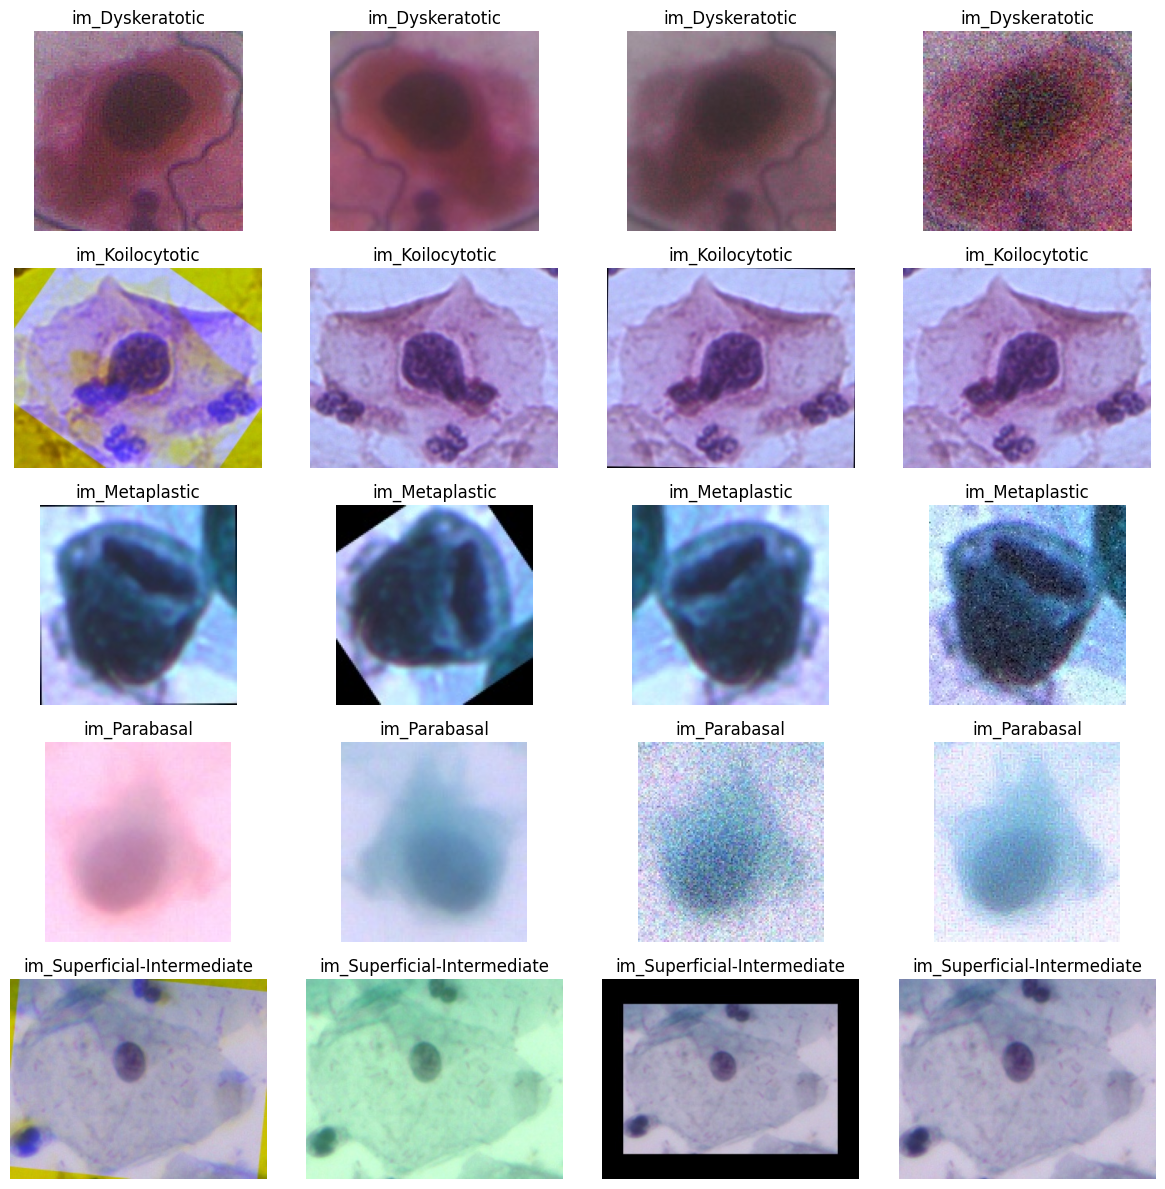

In [11]:
# Viewing impact of the augumentation techniques on the data 4 each

import matplotlib.pyplot as plt


num_images_to_display = 4

# Setting subplots
fig, axes = plt.subplots(len(class_names), num_images_to_display, figsize=(12, 12))

# Iterate over the class indices
for class_index, class_name in enumerate(class_names):

    # Get the path of the current class
    class_path = os.path.join(train_directory, class_name)

    # Get the list of augmented image files
    augmented_files = [file for file in os.listdir(class_path) if file.startswith("augmented_")]

    # To randomly select the desired number of images
    selected_files = random.sample(augmented_files, num_images_to_display)

    # To display the augmented images with labels
    for i, file_name in enumerate(selected_files):
        file_path = os.path.join(class_path, file_name)
        augmented_image = cv2.imread(file_path)
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

        # To display the image with the class label in the subplot
        axes[class_index, i].imshow(augmented_image)
        axes[class_index, i].set_title(class_name)
        axes[class_index, i].axis('off')

# spacing between subplots
plt.tight_layout()


plt.show()


In [12]:
train_directory

'D:\\cervical_cells\\split_unprocessed_images\\train'

In [13]:
# For extracting number of output classes
folders = glob.glob(r"D:\cervical_cells\split_unprocessed_images\train\*")

# To find number of classes for classification
number_of_class = len(folders)
number_of_class

5

In [14]:
# Train, test and validation data generator
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   rotation_range = 5, fill_mode="nearest",
                                   zoom_range=[1/1.0, 1/1.0], width_shift_range=0.0, height_shift_range=0.0,
                                   horizontal_flip = True, vertical_flip=True,
                                   brightness_range=[0.5, 1.3], channel_shift_range=20)

val_test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(train_directory,
                                                target_size=(224, 224), # typical imagenet dimensions
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical', shuffle=True)



validation_generator = val_test_datagen.flow_from_directory(validation_directory,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                shuffle=True)



test_generator = val_test_datagen.flow_from_directory(test_directory,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)

Found 2949 images belonging to 5 classes.
Found 810 images belonging to 5 classes.
Found 405 images belonging to 5 classes.


## MobileNetV3Large

In [14]:
import numpy as np
from keras.layers import Dense,GlobalAveragePooling2D, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.applications import MobileNetV3Large
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [37]:
# Building Model and fine tuning
MN3L_base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in MN3L_base_model.layers[:200]:
        layer.trainable = False
for layer in MN3L_base_model.layers[200:]:
        layer.trainable = True
        
x = MN3L_base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(number_of_class, activation='softmax')(x)
MN3L_model = Model(inputs=MN3L_base_model.input, outputs=preds)

MN3L_model.summary()
epochs = 50
optimizer = Adam(learning_rate=1e-3)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
MN3L_model.compile(optimizer=optimizer, 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_122 (ReLU)               (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_122[0][0]']              
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_127 (ReLU)               (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_127[0][0]']              
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 a)                                                                                               
                                                                                                  
 multiply_64 (Multiply)         (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_91[0][0]']    
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_64[0][0]']            
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_95 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_139 (ReLU)               (None, 14, 14, 184)  0           ['tf.__operators__.add_95[0][0]']
                                                                                                  
 tf.math.multiply_95 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_139[0][0]']              
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_70[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_98[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 D)                                                                                               
                                                                                                  
 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_102 (TFOp  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 Lambda)                                                         rm[0][0]']                       
                                                                                                  
 re_lu_146 (ReLU)               (None, 14, 14, 672)  0           ['tf.__operators__.add_102[0][0]'
                                                                 ]                                
          

 tf.math.multiply_105 (TFOpLamb  (None, 7, 7, 960)   0           ['re_lu_149[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_75 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_13/expand/BatchNo
                                                                 rm[0][0]',                       
                                                                  'tf.math.multiply_105[0][0]']   
                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_75[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_

                                                                                                  
 expanded_conv_14/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_14/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_109 (TFOp  (None, 7, 7, 960)   0           ['expanded_conv_14/depthwise/Batc
 Lambda)                                                         hNorm[0][0]']                    
                                                                                                  
 re_lu_153 (ReLU)               (None, 7, 7, 960)    0           ['tf.__operators__.add_109[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.m

                                                                                                  
 dense_5 (Dense)                (None, 5)            5125        ['dropout_5[0][0]']              
                                                                                                  
Total params: 3,993,477
Trainable params: 3,077,869
Non-trainable params: 915,608
__________________________________________________________________________________________________


In [39]:
# Training the MobileNetv3Large Model
h = MN3L_model.fit(train_generator, epochs=epochs, 
                  validation_data=validation_generator, 
                  callbacks=[early_stopping])

Epoch 1/50
123/123 [==============================] - 363s 3s/step - loss: 0.5787 - accuracy: 0.8417 - val_loss: 1.2778 - val_accuracy: 0.8119
Epoch 2/50
123/123 [==============================] - 317s 3s/step - loss: 0.2660 - accuracy: 0.9187 - val_loss: 1.4548 - val_accuracy: 0.8514
Epoch 3/50
123/123 [==============================] - 316s 3s/step - loss: 0.2041 - accuracy: 0.9391 - val_loss: 1.3702 - val_accuracy: 0.9202
Epoch 4/50
123/123 [==============================] - 309s 3s/step - loss: 0.1687 - accuracy: 0.9444 - val_loss: 1.1057 - val_accuracy: 0.8507
Epoch 5/50
123/123 [==============================] - 317s 3s/step - loss: 0.1639 - accuracy: 0.9467 - val_loss: 0.4169 - val_accuracy: 0.9196
Epoch 6/50
123/123 [==============================] - 328s 3s/step - loss: 0.1517 - accuracy: 0.9536 - val_loss: 0.2948 - val_accuracy: 0.9489
Epoch 7/50
123/123 [==============================] - 312s 3s/step - loss: 0.1178 - accuracy: 0.9574 - val_loss: 5.1066 - val_accuracy: 0.8603

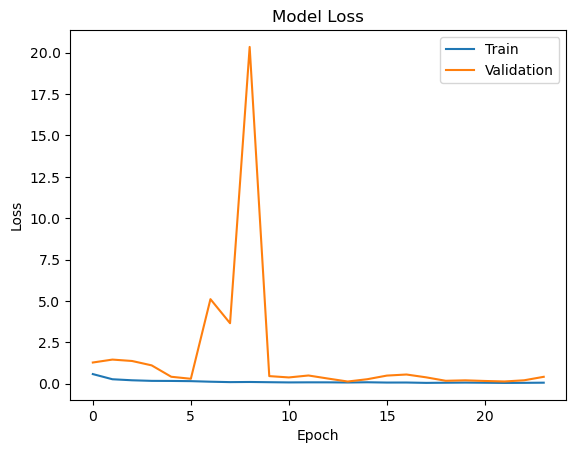

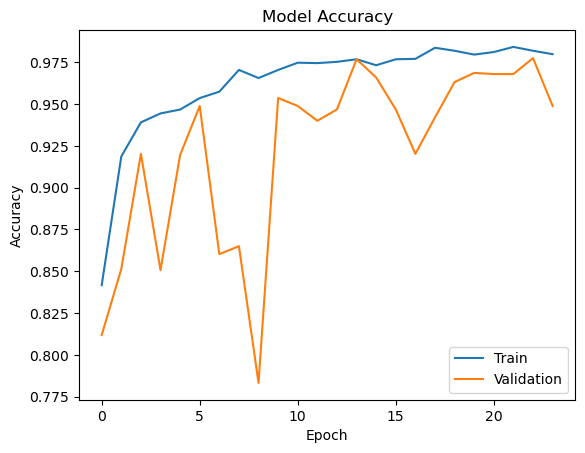

In [40]:
# For graphs
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [41]:
# import numpy as np
# from sklearn.metrics import classification_report

# # Make predictions on the test set
y_true = test_generator.classes
y_pred = MN3L_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Generate the classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)


765/765 [==============================] - 40s 46ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.98      1.00      0.99       141
            im_Koilocytotic       0.94      0.96      0.95       154
             im_Metaplastic       0.98      0.92      0.95       153
               im_Parabasal       0.99      0.99      0.99       157
im_Superficial-Intermediate       0.98      0.99      0.99       160

                   accuracy                           0.97       765
                  macro avg       0.97      0.97      0.97       765
               weighted avg       0.97      0.97      0.97       765



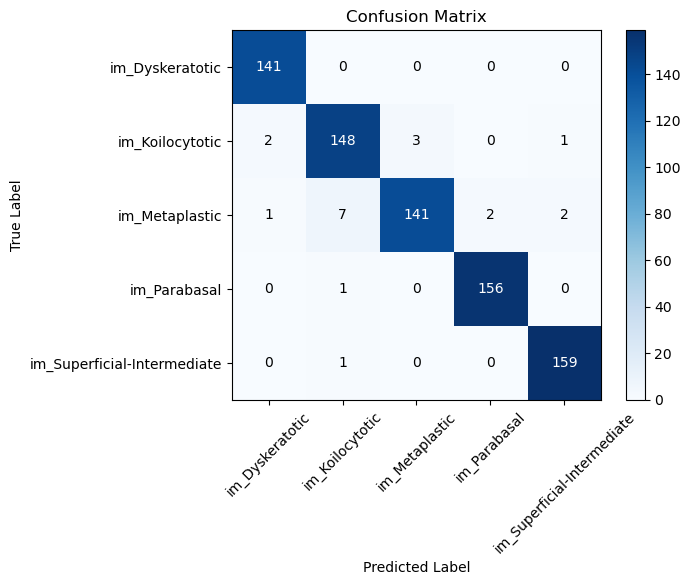

In [44]:
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt


# # Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix with annotations
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = test_generator.class_indices
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add annotations to the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [45]:
# Define the file path for saving the model
model_path = r"C:\Users\Mexy\Documents\Hull Workshop\Research\data for research\MN3L_model.h5"

# Save the model
MN3L_model.save(model_path)

print("Model saved successfully.")


Model saved successfully.


In [46]:
import pickle

pickle.dump(MN3L_model, open('My_MN3L_model.pkl','wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\add
......vars
...layers\add_1
......vars
...layers\add_2
......vars
...layers\add_3
......vars
...layers\add_4
......vars
...layers\add_5
......vars
...layers\add_6
......vars
...layers\add_7
......vars
...layers\add_8
......vars
...layers\add_9
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_10
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_11
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_12
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_13
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_14
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_15
......vars
.........0

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-07-18 23:26:21       125757
metadata.json                                  2023-07-18 23:26:21           64
variables.h5                                   2023-07-18 23:26:22     16598840


In [47]:
# save model weights
MN3L_model.save_weights("mobnetL.h5")

## MobileNetv3Small

In [49]:
from keras.applications import MobileNetV3Small

In [50]:
# Building and Fine tuning
MN3S_base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in MN3S_base_model.layers[:200]:
        layer.trainable = False
for layer in MN3S_base_model.layers[200:]:
        layer.trainable = True
        
x = MN3S_base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(number_of_class, activation='softmax')(x)
MN3S_model = Model(inputs=MN3S_base_model.input, outputs=preds)

MN3S_model.summary()
epochs = 50
optimizer = Adam(learning_rate=1e-3)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
MN3S_model.compile(optimizer=optimizer, 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_4[0][0]']            
                                )                                                                 
                                                                                            

                                                                                                  
 expanded_conv_1/depthwise/Batc  (None, 28, 28, 72)  288         ['expanded_conv_1/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_160 (ReLU)               (None, 28, 28, 72)   0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 28, 28, 24)  1728        ['re_lu_160[0][0]']              
 D)                                                                                               
                                                                                                  
 expanded_

 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    0           ['multiply_82[0][0]']            
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    2328        ['expanded_conv_3/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_

 Lambda)                                                         Conv_1[0][0]']                   
                                                                                                  
 re_lu_168 (ReLU)               (None, 1, 1, 240)    0           ['tf.__operators__.add_119[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.multiply_119 (TFOpLamb  (None, 1, 1, 240)   0           ['re_lu_168[0][0]']              
 da)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 14, 14, 240)  0          ['multiply_84[0][0]',            
 /Mul (Multiply)                                                  'tf.math.multiply_119[0][0]']   
          

 /Mul (Multiply)                                                  'tf.math.multiply_122[0][0]']   
                                                                                                  
 expanded_conv_5/project (Conv2  (None, 14, 14, 40)  9600        ['expanded_conv_5/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_5/project/BatchN  (None, 14, 14, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 14, 14, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
          

                                                                                                  
 expanded_conv_7/expand/BatchNo  (None, 14, 14, 144)  576        ['expanded_conv_7/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_126 (TFOp  (None, 14, 14, 144)  0          ['expanded_conv_7/expand/BatchNor
 Lambda)                                                         m[0][0]']                        
                                                                                                  
 re_lu_175 (ReLU)               (None, 14, 14, 144)  0           ['tf.__operators__.add_126[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_129 (TFOpLamb  (None, 14, 14, 288)  0          ['re_lu_178[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_91 (Multiply)         (None, 14, 14, 288)  0           ['expanded_conv_8/expand/BatchNor
                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_129[0][0]']   
                                                                                                  
 expanded_conv_8/depthwise/pad   (None, 17, 17, 288)  0          ['multiply_91[0][0]']            
 (ZeroPadding2D)                                                                                  
          

 expanded_conv_9/depthwise/Batc  (None, 7, 7, 576)   2304        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_133 (TFOp  (None, 7, 7, 576)   0           ['expanded_conv_9/depthwise/Batch
 Lambda)                                                         Norm[0][0]']                     
                                                                                                  
 re_lu_182 (ReLU)               (None, 7, 7, 576)    0           ['tf.__operators__.add_133[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.multiply_133 (TFOpLamb  (None, 7, 7, 576)   0           ['re_lu_182[0][0]']              
 da)      

 tf.math.multiply_136 (TFOpLamb  (None, 7, 7, 576)   0           ['re_lu_185[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_96 (Multiply)         (None, 7, 7, 576)    0           ['expanded_conv_10/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_136[0][0]']   
                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 1, 1, 576)   0           ['multiply_96[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

In [51]:
# Training the MobileNetv3Small Model
s = MN3S_model.fit(train_generator, epochs=epochs, 
                  validation_data=validation_generator, 
                  callbacks=[early_stopping])

Epoch 1/50
123/123 [==============================] - 214s 2s/step - loss: 0.6657 - accuracy: 0.8091 - val_loss: 0.3308 - val_accuracy: 0.8943
Epoch 2/50
123/123 [==============================] - 178s 1s/step - loss: 0.3673 - accuracy: 0.8858 - val_loss: 0.2553 - val_accuracy: 0.9237
Epoch 3/50
123/123 [==============================] - 183s 1s/step - loss: 0.2813 - accuracy: 0.9087 - val_loss: 0.2581 - val_accuracy: 0.9148
Epoch 4/50
123/123 [==============================] - 177s 1s/step - loss: 0.2386 - accuracy: 0.9223 - val_loss: 0.1886 - val_accuracy: 0.9373
Epoch 5/50
123/123 [==============================] - 178s 1s/step - loss: 0.1971 - accuracy: 0.9340 - val_loss: 0.3028 - val_accuracy: 0.9059
Epoch 6/50
123/123 [==============================] - 184s 1s/step - loss: 0.1588 - accuracy: 0.9465 - val_loss: 0.1819 - val_accuracy: 0.9414
Epoch 7/50
123/123 [==============================] - 178s 1s/step - loss: 0.1461 - accuracy: 0.9485 - val_loss: 0.1748 - val_accuracy: 0.9489

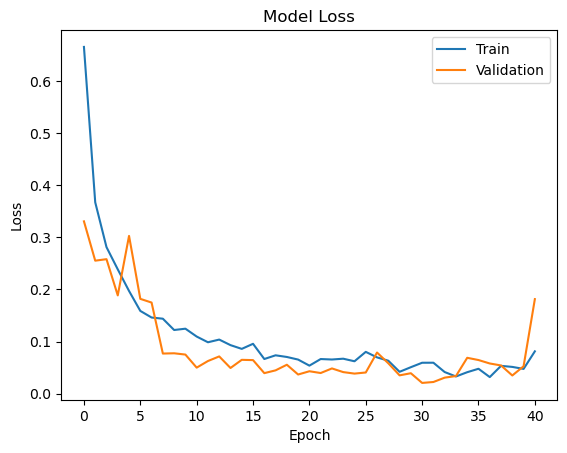

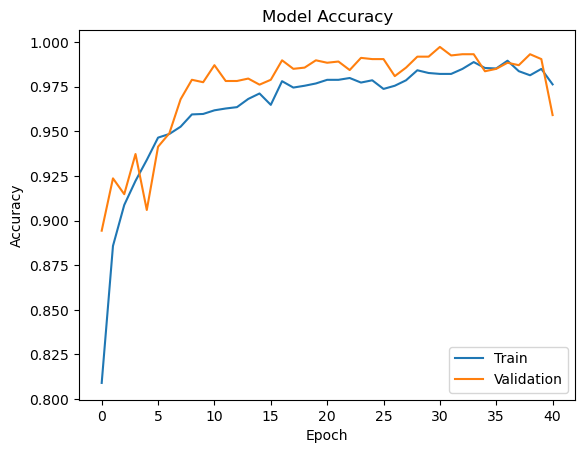

In [52]:
# For graphs
plt.plot(s.history['loss'])
plt.plot(s.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.plot(s.history['accuracy'])
plt.plot(s.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [53]:
# Make predictions on the test set
y_true = test_generator.classes
y_pred = MN3S_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Generate the classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)


765/765 [==============================] - 20s 24ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       1.00      1.00      1.00       141
            im_Koilocytotic       0.97      0.99      0.98       154
             im_Metaplastic       0.99      0.97      0.98       153
               im_Parabasal       1.00      1.00      1.00       157
im_Superficial-Intermediate       0.99      1.00      1.00       160

                   accuracy                           0.99       765
                  macro avg       0.99      0.99      0.99       765
               weighted avg       0.99      0.99      0.99       765



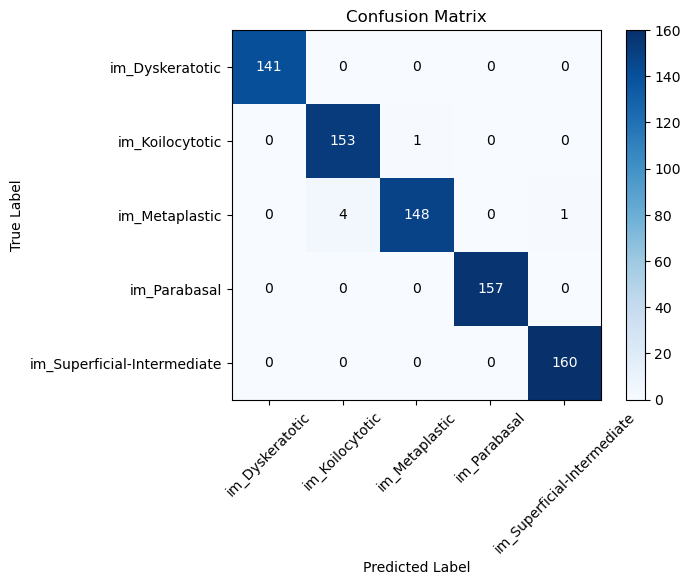

In [54]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with annotations
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = test_generator.class_indices
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Adding annotations to the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [55]:

# Save the model
MN3S_model.save('MN3S_model.h5')

print("Model saved successfully.")

Model saved successfully.


In [56]:

pickle.dump(MN3S_model, open('My_MN3S_model.pkl','wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\add
......vars
...layers\add_1
......vars
...layers\add_2
......vars
...layers\add_3
......vars
...layers\add_4
......vars
...layers\add_5
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_10
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_11
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_12
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_13
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_14
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_15
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_16
......vars
.........0
.........1
........

File Name                                             Modified             Size
config.json                                    2023-07-19 06:02:18       107171
metadata.json                                  2023-07-19 06:02:18           64
variables.h5                                   2023-07-19 06:02:19      6704496


## RESNET50 Model

In [15]:
from keras.applications import ResNet50

In [16]:
# Building and fine tuning
Res50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in Res50_base_model.layers[:80]:
        layer.trainable = False
for layer in Res50_base_model.layers[80:]:
        layer.trainable = True
        
x = Res50_base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(number_of_class, activation='softmax')(x)
Res50_model = Model(inputs=Res50_base_model.input, outputs=preds)

Res50_model.summary()
epochs = 50
optimizer = Adam(learning_rate=1e-3)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
Res50_model.compile(optimizer=optimizer, 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [17]:
# Training the MobileNetv3Small Model
r = Res50_model.fit(train_generator, epochs=epochs, 
                  validation_data=validation_generator, 
                  callbacks=[early_stopping])

Epoch 1/50
123/123 [==============================] - 1863s 15s/step - loss: 0.8328 - accuracy: 0.7767 - val_loss: 90.3138 - val_accuracy: 0.2890
Epoch 2/50
123/123 [==============================] - 1783s 14s/step - loss: 0.3617 - accuracy: 0.8919 - val_loss: 0.2114 - val_accuracy: 0.9209
Epoch 3/50
123/123 [==============================] - 1807s 15s/step - loss: 0.2828 - accuracy: 0.9126 - val_loss: 0.2258 - val_accuracy: 0.9475
Epoch 4/50
123/123 [==============================] - 1812s 15s/step - loss: 0.2753 - accuracy: 0.9118 - val_loss: 2.6196 - val_accuracy: 0.8091
Epoch 5/50
123/123 [==============================] - 1803s 15s/step - loss: 0.2623 - accuracy: 0.9192 - val_loss: 0.1593 - val_accuracy: 0.9434
Epoch 6/50
123/123 [==============================] - 1758s 14s/step - loss: 0.1835 - accuracy: 0.9396 - val_loss: 0.0771 - val_accuracy: 0.9700
Epoch 7/50
123/123 [==============================] - 1804s 15s/step - loss: 0.1985 - accuracy: 0.9358 - val_loss: 0.1081 - val_a

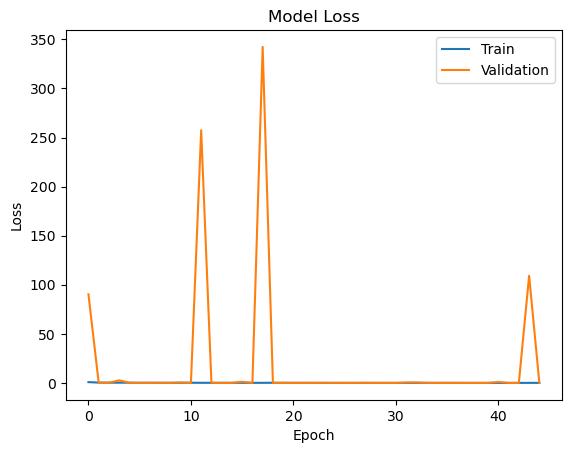

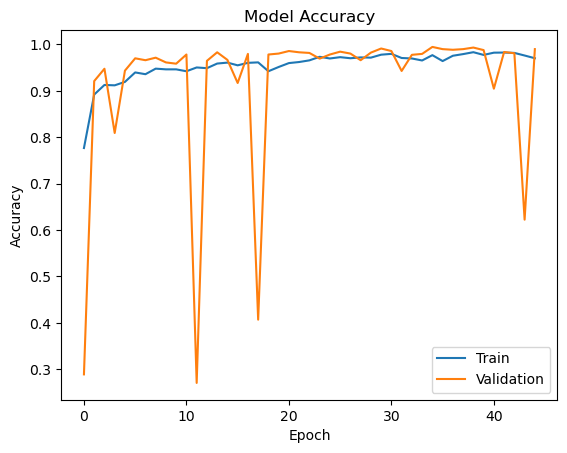

In [18]:
# For graphs

plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [20]:
# # Make predictions on the test set
y_true = test_generator.classes
y_pred = Res50_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Generate the classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)

765/765 [==============================] - 177s 230ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.99      1.00      0.99       141
            im_Koilocytotic       0.99      0.97      0.98       154
             im_Metaplastic       0.97      0.99      0.98       153
               im_Parabasal       1.00      0.98      0.99       157
im_Superficial-Intermediate       0.99      1.00      1.00       160

                   accuracy                           0.99       765
                  macro avg       0.99      0.99      0.99       765
               weighted avg       0.99      0.99      0.99       765



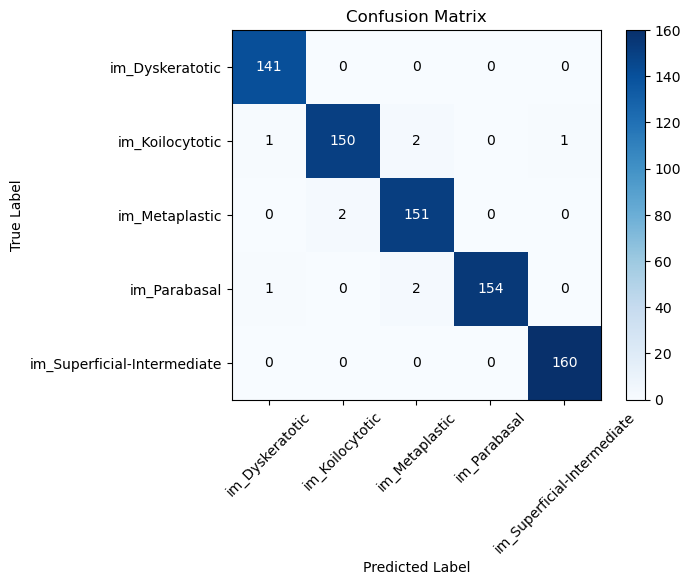

In [21]:
# # Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with annotations
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = test_generator.class_indices
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add annotations to the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [22]:
# Save the model
Res50_model.save('Res50_model.h5')

print("Model saved successfully.")

Model saved successfully.


In [25]:
pickle.dump(Res50_model, open('My_Res50_model.pkl','wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_10
......vars
...layers\activation_11
......vars
...layers\activation_12
......vars
...layers\activation_13
......vars
...layers\activation_14
......vars
...layers\activation_15
......vars
...layers\activation_16
......vars
...layers\activation_17
......vars
...layers\activation_18
......vars
...layers\activation_19
......vars
...layers\activation_2
......vars
...layers\activation_20
......vars
...layers\activation_21
......vars
...layers\activation_22
......vars
...layers\activation_23
......vars
...layers\activation_24
......vars
...layers\activation_25
......vars
...layers\activation_26
......vars
...layers\activation_27
......vars
...layers\activation_28
......vars
...layers\activation_29
......vars
...layers\activation_3
......vars
...layers\activation_30
......vars
...layers\activation_31
......vars
...layers\activation_32
......

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-07-20 12:53:45        87791
metadata.json                                  2023-07-20 12:53:45           64
variables.h5                                   2023-07-20 12:53:48    103283568


## CNN model

In [32]:
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential

# Building the model
cnn_model = Sequential() 

# Convolutional Layer with input shape (64,64,3)
cnn_model.add(Conv2D(filters=32, kernel_size= (3,3), activation= 'relu', input_shape=(224,224,3)) )

cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
cnn_model.add(MaxPool2D(pool_size=(2,2)))



cnn_model.add(Flatten())
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dense(units=5, activation='softmax'))

cnn_model.compile(optimizer= Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])


cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 128)      

In [33]:
# Training
c = cnn_model.fit(train_generator, epochs=epochs, 
                  validation_data=validation_generator, 
                  callbacks=[early_stopping])

Epoch 1/50
123/123 [==============================] - 733s 6s/step - loss: 19.3997 - accuracy: 0.5037 - val_loss: 1.0896 - val_accuracy: 0.6524
Epoch 2/50
123/123 [==============================] - 707s 6s/step - loss: 1.0572 - accuracy: 0.6258 - val_loss: 1.0872 - val_accuracy: 0.6455
Epoch 3/50
123/123 [==============================] - 701s 6s/step - loss: 0.9676 - accuracy: 0.6607 - val_loss: 0.7409 - val_accuracy: 0.7335
Epoch 4/50
123/123 [==============================] - 706s 6s/step - loss: 0.8773 - accuracy: 0.6903 - val_loss: 0.6925 - val_accuracy: 0.7580
Epoch 5/50
123/123 [==============================] - 695s 6s/step - loss: 0.8427 - accuracy: 0.7137 - val_loss: 0.6196 - val_accuracy: 0.7853
Epoch 6/50
123/123 [==============================] - 695s 6s/step - loss: 0.7797 - accuracy: 0.7288 - val_loss: 0.6478 - val_accuracy: 0.7669
Epoch 7/50
123/123 [==============================] - 706s 6s/step - loss: 0.7743 - accuracy: 0.7443 - val_loss: 0.5560 - val_accuracy: 0.805

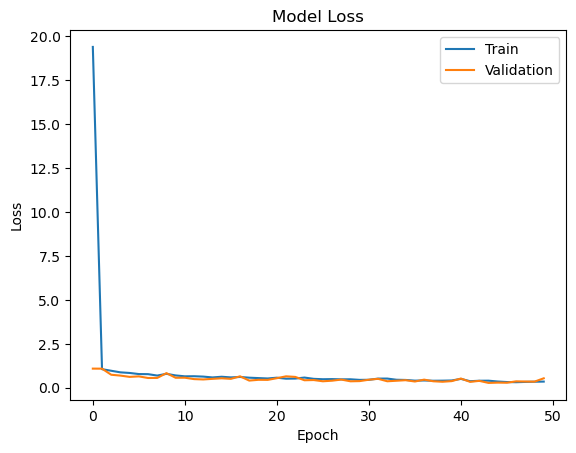

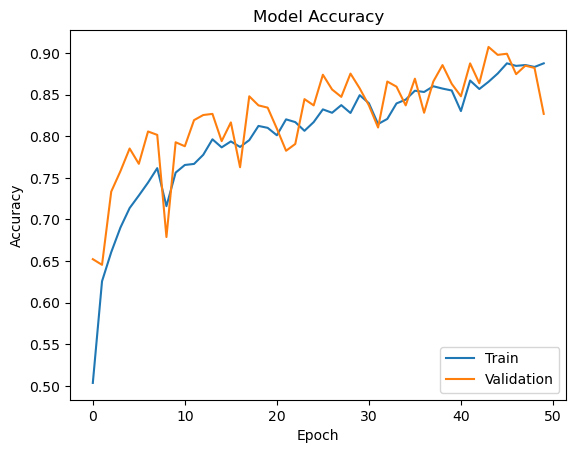

In [34]:
# For graphs

plt.plot(c.history['loss'])
plt.plot(c.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.plot(c.history['accuracy'])
plt.plot(c.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [35]:
# # Make predictions on the test set
y_true = test_generator.classes
y_pred = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Generate the classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)

765/765 [==============================] - 52s 62ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       1.00      0.72      0.83       141
            im_Koilocytotic       0.79      0.71      0.75       154
             im_Metaplastic       0.89      0.86      0.87       153
               im_Parabasal       0.87      0.98      0.92       157
im_Superficial-Intermediate       0.76      0.94      0.84       160

                   accuracy                           0.85       765
                  macro avg       0.86      0.84      0.84       765
               weighted avg       0.86      0.85      0.84       765



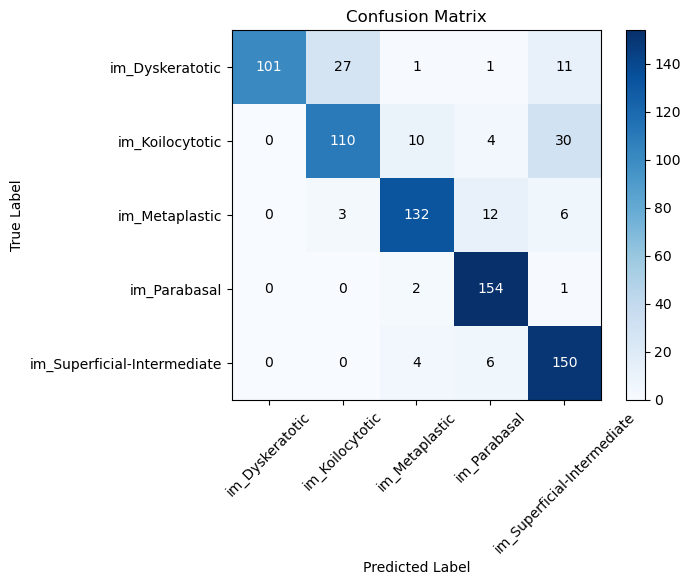

In [36]:
# # Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with annotations
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = test_generator.class_indices
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add annotations to the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Vision Transformer(ViT) Model

In [8]:
# pip install timm


Error processing line 1 of C:\Users\Mexy\anaconda3\lib\site-packages\vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\Mexy\anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 2.2/2.2 MB 1.3 MB/s eta 0:00:00
     -------------------------------------- 263.9/263.9 kB 1.8 MB/s eta 0:00:00


In [52]:
pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [23]:
#ViT model with pretrained weights
pretrained_vit = timm.create_model('vit_base_patch16_224', pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_vit.to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Unfreeze some layers
unfreeze_layers = ['blocks.10', 'blocks.11', 'head']
for name, parameter in pretrained_vit.named_parameters():
    for layer_name in unfreeze_layers:
        if layer_name in name:
            parameter.requires_grad = True

# Changing classification head
pretrained_vit.head = nn.Linear(in_features=pretrained_vit.num_features, out_features=number_of_class).to(device)

# model summary
summary(pretrained_vit, input_size=(3, 224, 224), device=device.type)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
          Dropout-11         [-1, 12, 197, 197]               0
           Linear-12             [-1, 197, 768]         590,592
          Dropout-13             [-1, 197, 768]               0
        Attention-14             [-1, 1

In [25]:
# Train, test, and validation data loader
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_directory, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

validation_dataset = ImageFolder(validation_directory, transform=val_test_transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4)

test_dataset = ImageFolder(test_directory, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [31]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_vit.parameters(), lr=0.001)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
def train():
    pretrained_vit.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = pretrained_vit(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

# Validation loop
def validate():
    pretrained_vit.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pretrained_vit(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    accuracy = 100 * correct / total
    epoch_loss = running_loss / len(validation_loader)
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)
    return accuracy

# Training and validation
num_epochs = 10
for epoch in range(num_epochs):
    train()
    accuracy = validate()
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Training Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Validation Accuracy: {val_accuracies[-1]:.2f}%, '
          f'Training Loss: {train_losses[-1]:.4f}, '
          f'Validation Loss: {val_losses[-1]:.4f}')

Epoch [1/10] - Training Accuracy: 98.34%, Validation Accuracy: 92.59%, Training Loss: 0.0625, Validation Loss: 0.3353
Epoch [2/10] - Training Accuracy: 98.91%, Validation Accuracy: 93.33%, Training Loss: 0.0324, Validation Loss: 0.2951
Epoch [3/10] - Training Accuracy: 99.22%, Validation Accuracy: 92.72%, Training Loss: 0.0263, Validation Loss: 0.3214
Epoch [4/10] - Training Accuracy: 99.25%, Validation Accuracy: 95.19%, Training Loss: 0.0240, Validation Loss: 0.1851
Epoch [5/10] - Training Accuracy: 99.73%, Validation Accuracy: 93.46%, Training Loss: 0.0079, Validation Loss: 0.3988
Epoch [6/10] - Training Accuracy: 98.47%, Validation Accuracy: 92.47%, Training Loss: 0.0505, Validation Loss: 0.6596
Epoch [7/10] - Training Accuracy: 98.17%, Validation Accuracy: 94.07%, Training Loss: 0.0656, Validation Loss: 0.2216
Epoch [8/10] - Training Accuracy: 99.39%, Validation Accuracy: 93.83%, Training Loss: 0.0175, Validation Loss: 0.3576
Epoch [9/10] - Training Accuracy: 99.02%, Validation Acc

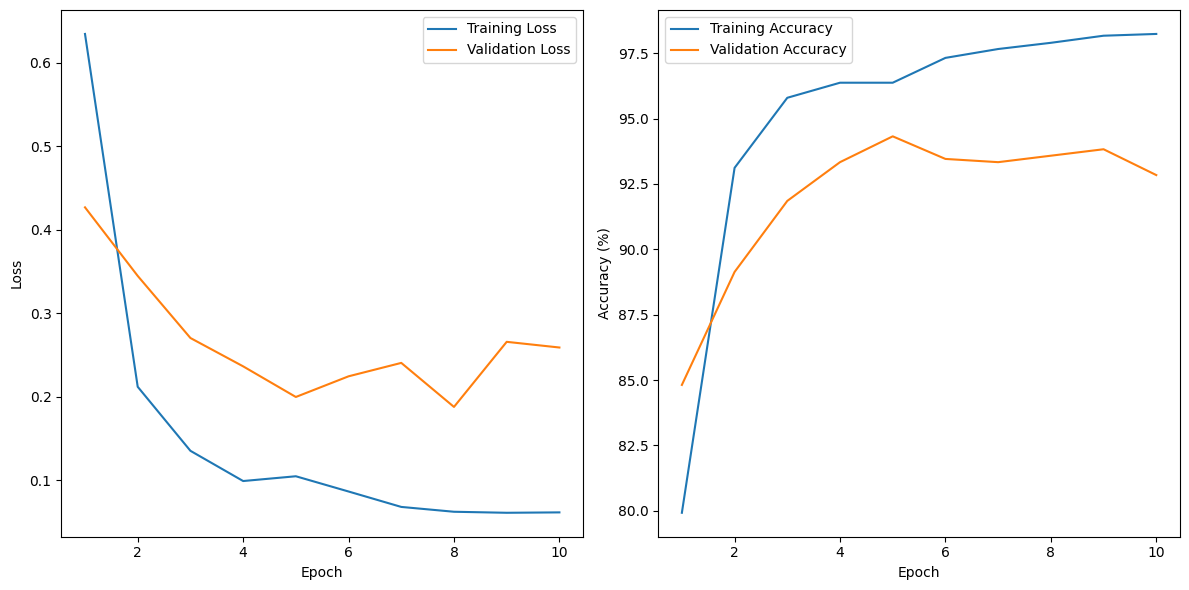

In [66]:
# Plot the training and validation metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

pretrained_vit.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_vit(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


print(classification_report(y_true, y_pred, target_names=class_names))


                             precision    recall  f1-score   support

            im_Dyskeratotic       0.97      0.93      0.95        82
            im_Koilocytotic       0.92      0.92      0.92        84
             im_Metaplastic       0.89      0.96      0.93        78
               im_Parabasal       0.99      0.99      0.99        85
im_Superficial-Intermediate       0.99      0.96      0.97        76

                   accuracy                           0.95       405
                  macro avg       0.95      0.95      0.95       405
               weighted avg       0.95      0.95      0.95       405



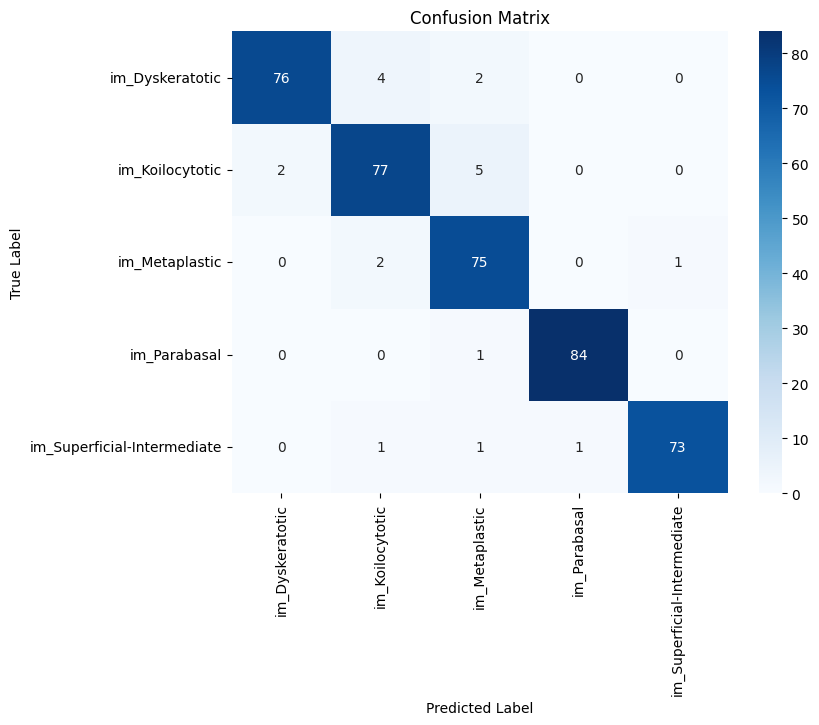

In [74]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [79]:
# Saving Model

# Move the model's state dictionary from GPU to CPU before saving
pretrained_vit.cpu()

# Save the model on CPU
torch.save(pretrained_vit.state_dict(), 'pretrained_vit_model.pth')


## Ensemble Model

In [16]:
# Combining models to create a more superior model
from keras.models import load_model
from keras.layers import Input, average

## loading models
model1 = load_model('D:\cervical_cells\MN3L_model.h5')
model2 = load_model('MN3S_model.h5')
model3 = load_model('D:\cervical_cells\Res50_model.h5')

## Building ensemble model
model1 = Model(inputs = model1.inputs,outputs=model1.outputs,name = 'Mobilenet3large')
model2 = Model(inputs = model2.inputs,outputs=model2.outputs,name = 'MobileNet3Small')
model3 = Model(inputs = model3.inputs,outputs=model3.outputs,name = 'res50')

models = [model1,model2,model3]
model_input = Input(shape=(224,224,3))
model_outputs = [model(model_input) for model in models]
ensemble_output = average(model_outputs)
ensemble_model = Model(inputs = model_input, outputs = ensemble_output, name = 'ensemble')



In [17]:
ensemble_model.summary()
epochs = 10
optimizer = Adam(learning_rate=1e-3)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
ensemble_model.compile(optimizer=optimizer, 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Mobilenet3large (Functional)   (None, 5)            3993477     ['input_1[0][0]']                
                                                                                                  
 MobileNet3Small (Functional)   (None, 5)            1541493     ['input_1[0][0]']                
                                                                                                  
 res50 (Functional)             (None, 5)            25703301    ['input_1[0][0]']         

In [22]:
# Training
e = ensemble_model.fit(train_generator, epochs=epochs, 
                  validation_data=validation_generator, 
                  callbacks=[early_stopping])

Epoch 1/10
93/93 [==============================] - 39s 419ms/step - loss: 0.0705 - accuracy: 0.9858 - val_loss: 0.2523 - val_accuracy: 0.9481
Epoch 2/10
93/93 [==============================] - 20s 210ms/step - loss: 0.0785 - accuracy: 0.9807 - val_loss: 0.1817 - val_accuracy: 0.9654
Epoch 3/10
93/93 [==============================] - 20s 211ms/step - loss: 0.0734 - accuracy: 0.9827 - val_loss: 0.2531 - val_accuracy: 0.9654
Epoch 4/10
93/93 [==============================] - 19s 209ms/step - loss: 0.0760 - accuracy: 0.9820 - val_loss: 0.2127 - val_accuracy: 0.9667
Epoch 5/10
93/93 [==============================] - 20s 211ms/step - loss: 0.0707 - accuracy: 0.9830 - val_loss: 0.1296 - val_accuracy: 0.9765
Epoch 6/10
93/93 [==============================] - 20s 209ms/step - loss: 0.0478 - accuracy: 0.9878 - val_loss: 0.1775 - val_accuracy: 0.9802
Epoch 7/10
93/93 [==============================] - 27s 293ms/step - loss: 0.0509 - accuracy: 0.9902 - val_loss: 0.1353 - val_accuracy: 0.9864

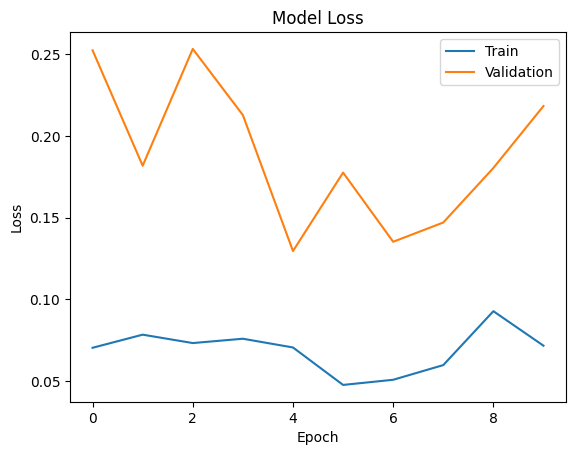

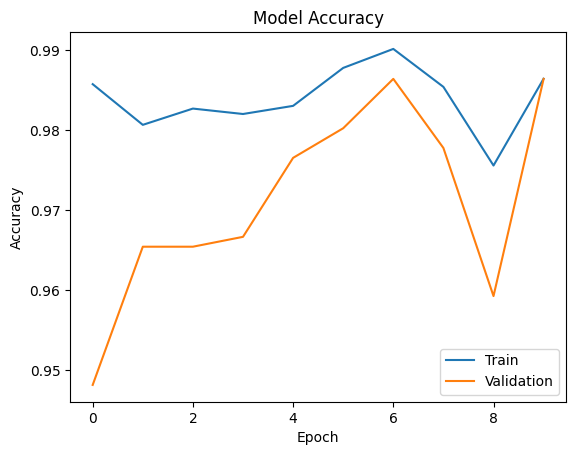

In [23]:
plt.plot(e.history['loss'])
plt.plot(e.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


plt.plot(e.history['accuracy'])
plt.plot(e.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [24]:
# import numpy as np
# from sklearn.metrics import classification_report

# # Make predictions on the test set
y_true = test_generator.classes
y_pred = ensemble_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Generate the classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)

405/405 [==============================] - 12s 24ms/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.98      0.99      0.98        82
            im_Koilocytotic       0.98      0.98      0.98        84
             im_Metaplastic       1.00      0.99      0.99        78
               im_Parabasal       0.98      0.99      0.98        85
im_Superficial-Intermediate       1.00      0.99      0.99        76

                   accuracy                           0.99       405
                  macro avg       0.99      0.99      0.99       405
               weighted avg       0.99      0.99      0.99       405



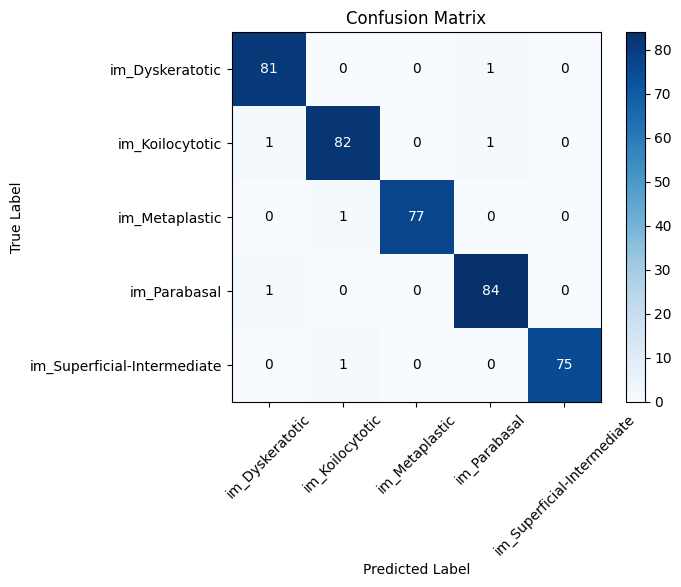

In [25]:
# # Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with annotations
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = test_generator.class_indices
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add annotations to the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [33]:
# Save the model
ensemble_model.save('D:\cervical_cells\ensemble_model_v2.h5')

print("Model saved successfully.")

pickle.dump(ensemble_model, open('D:\cervical_cells\My_ensemble_model.pkl','wb'))

Model saved successfully.


INFO:tensorflow:Assets written to: ram://606de3b2-381e-40c5-b6bc-93460ef8f4d7/assets


INFO:tensorflow:Assets written to: ram://606de3b2-381e-40c5-b6bc-93460ef8f4d7/assets


In [1]:
pip freeze | grep tensorflow


Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
pip freeze | findstr tensorflow


tensorflow==2.11.0Note: you may need to restart the kernel to use updated packages.


Error processing line 1 of C:\Users\Mexy\anaconda3\lib\site-packages\vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\Mexy\anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored



tensorflow-addons==0.20.0
tensorflow-estimator==2.11.0
tensorflow-intel==2.11.0
tensorflow-io-gcs-filesystem==0.29.0


In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


Error processing line 1 of C:\Users\Mexy\anaconda3\lib\site-packages\vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\Mexy\anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [5]:
import flask
import tensorflow
import numpy
import requests
import werkzeug
import PIL
import sklearn
import gunicorn

print("Flask version:", flask.__version__)
print("TensorFlow version:", tensorflow.__version__)
print("NumPy version:", numpy.__version__)
print("Requests version:", requests.__version__)
print("Werkzeug version:", werkzeug.__version__)
print("PIL (Pillow) version:", PIL.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Gunicorn version:", gunicorn.__version__)


Flask version: 1.1.2
TensorFlow version: 2.11.0
NumPy version: 1.21.5
Requests version: 2.28.1
Werkzeug version: 2.0.3
PIL (Pillow) version: 9.2.0
scikit-learn version: 1.0.2
Gunicorn version: 21.2.0


In [11]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

def classify_image(image_path):
    # Loading the model
    model = load_model(r"C:\Users\Mexy\Documents\Hull Workshop\Research\MN3S_model.h5")
    
    # Preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize image

    # Make prediction
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions[0])  # Get the index of the highest predicted probability
    
    class_labels = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']

    predicted_class = class_labels[class_index]
    return predicted_class

result = classify_image(r"C:\Users\Mexy\Documents\Hull Workshop\Research\data for research\im_Parabasal\CROPPED\001_03.bmp")
print(result)


1/1 [==============================] - 1s 1s/step
Metaplastic


In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model
# from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

def classify_image(image_path):
    # Loading the model
    model = load_model(r"C:\Users\Mexy\Documents\Hull Workshop\Research\MN3S_model.h5")
    
    # Preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Apply the same preprocessing used during training
    img_array = preprocess_input(img_array)
    
    # Make prediction
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions[0])  # Get the index of the highest predicted probability
    
    class_labels = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']

    predicted_class = class_labels[class_index]
    return predicted_class

result = classify_image(r"C:\Users\Mexy\Documents\Hull Workshop\Research\data for research\im_Koilocytotic\CROPPED\002_01.bmp")
print(result)


1/1 [==============================] - 2s 2s/step
Koilocytotic
